In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = data = os.path.join(sys.path[0], "Week_3_Data.csv")
df = pd.read_csv(url)

In [27]:
columns = ['room_type', 'neighbourhood_group','latitude','longitude','price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']

df = df[columns]

df['reviews_per_month'] = df.reviews_per_month.fillna(0)

In [28]:
df['neighbourhood_group'].describe()

count         48895
unique            5
top       Manhattan
freq          21661
Name: neighbourhood_group, dtype: object

In [29]:
df_numerical = df.copy()
df_numerical.corr()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
latitude,1.000000,0.084788,0.033939,0.024869,-0.015389,-0.018758,0.019517,-0.010983
longitude,0.084788,1.000000,-0.150019,-0.062747,0.059094,0.138516,-0.114713,0.082731
price,0.033939,-0.150019,1.000000,0.042799,-0.047954,-0.050564,0.057472,0.081829
minimum_nights,0.024869,-0.062747,0.042799,1.000000,-0.080116,-0.124905,0.127960,0.144303
number_of_reviews,-0.015389,0.059094,-0.047954,-0.080116,1.000000,0.589407,-0.072376,0.172028
reviews_per_month,-0.018758,0.138516,-0.050564,-0.124905,0.589407,1.000000,-0.047312,0.163732
calculated_host_listings_count,0.019517,-0.114713,0.057472,0.127960,-0.072376,-0.047312,1.000000,0.225701
availability_365,-0.010983,0.082731,0.081829,0.144303,0.172028,0.163732,0.225701,1.000000


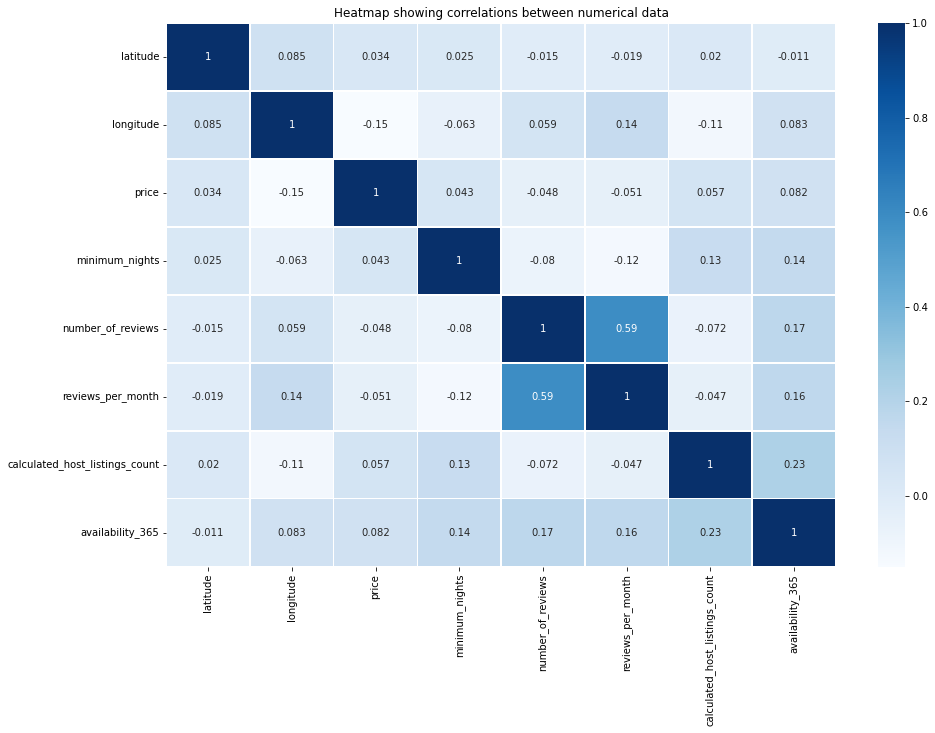

latitude                        latitude                          1.000000
longitude                       longitude                         1.000000
calculated_host_listings_count  calculated_host_listings_count    1.000000
reviews_per_month               reviews_per_month                 1.000000
number_of_reviews               number_of_reviews                 1.000000
                                                                    ...   
calculated_host_listings_count  longitude                        -0.114713
minimum_nights                  reviews_per_month                -0.124905
reviews_per_month               minimum_nights                   -0.124905
price                           longitude                        -0.150019
longitude                       price                            -0.150019
Length: 64, dtype: float64

In [30]:
plt.figure(figsize=(15,10))  
sns.heatmap(df_numerical.corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

df_numerical.corr().unstack().sort_values(ascending = False)


In [31]:
df_categorical = df.copy()

mean = df_categorical['price'].mean()

df_categorical['above_average'] = np.where(df_categorical['price'] >= mean,1,0)

df_categorical = df_categorical.drop('price', axis=1)

In [32]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df_categorical, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

In [33]:
from sklearn.metrics import mutual_info_score
from sklearn.metrics import mutual_info_score
print(mutual_info_score(df_train.above_average, df_train.neighbourhood_group).round(3))
print(mutual_info_score(df_train.above_average, df_train.room_type).round(3))

0.047
0.143


In [34]:
df_train = df_train.drop('above_average', axis=1)
df_val = df_val.drop('above_average', axis=1)
df_test = df_test.drop('above_average', axis=1)

In [35]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

categorical = ['neighbourhood_group','room_type']
numerical = ['latitude','longitude','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']

train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [36]:
model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict(X_val)

accuracy = np.round(accuracy_score(y_val, y_pred),2)
print(accuracy)

/home/kenwu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.79


In [37]:
features = categorical + numerical
orig_score = accuracy

for c in features:
    subset = features.copy()
    subset.remove(c)
    
    train_dict = df_train[subset].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)

    X_train = dv.transform(train_dict)

    model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)
    model.fit(X_train, y_train)

    val_dict = df_val[subset].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    y_pred = model.predict(X_val)

    score = accuracy_score(y_val, y_pred)
    print(c, orig_score - score, score)

neighbourhood_group 0.03992330504141528 0.7500766949585848


/home/kenwu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


room_type 0.07591880560384501 0.714081194396155


/home/kenwu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


latitude 0.003927804478985664 0.7860721955210144


/home/kenwu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


longitude 0.0040300644237653005 0.7859699355762347


/home/kenwu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


minimum_nights 0.005257183761120832 0.7847428162388792


/home/kenwu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


number_of_reviews 0.0033142448103078426 0.7866857551896922


/home/kenwu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


reviews_per_month 0.0066888229880356365 0.7833111770119644


/home/kenwu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


calculated_host_listings_count 0.003825544534206027 0.786174455465794


/home/kenwu/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


availability_365 0.008734021883628262 0.7812659781163718


In [38]:
df['price']=np.log1p(df['price'])

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

del df_train['price']
del df_val['price']
del df_test['price']

In [39]:
train_dict = df_train[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [40]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

for a in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(alpha=a,random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    print(a, round(score, 3))

0 0.497
0.01 0.497
0.1 0.497
1 0.497
10 0.498
